In [5]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cd /content/drive/My\ Drive/License_Plate/15.03.2021_working_code/

/content/drive/My Drive/License_Plate/15.03.2021_working_code


In [7]:
ls

1.png      cropped_lp.png                 __pycache__/
2.png      derained.png                   raindetected.png
car11.png  frozen_east_text_detection.pb  src_img.png
car1.PNG   GuidedFilter.py                testimages/
car2.jpg   LP_Rain_Streak_Detect.ipynb    TextDetection.png
car3.PNG   model/                         tools/
car4.jpg   model2/                        training.py
car5.jpg   photofunny.net_.jpg


In [8]:
%tensorflow_version 1.x

In [9]:
!pip install pytesseract
!pip install imutils

  Created wheel for pytesseract: filename=pytesseract-0.3.8-py2.py3-none-any.whl size=14072 sha256=e3f33528f6a5b73d9c957dc1d1d322833c0522bcf8359454825ca46874f21f06
  Stored in directory: /root/.cache/pip/wheels/a4/89/b9/3f11250225d0f90e5454fcc30fd1b7208db226850715aa9ace
Successfully built pytesseract


In [10]:
import numpy as np
import math
import cv2
from scipy.signal import convolve2d
from matplotlib import pyplot as plt
from imutils.object_detection import non_max_suppression
import time
from PIL import Image
import os
import tensorflow as tf
import training as Network
import matplotlib.image as img
import pytesseract # this is tesseract module 
import glob 
import imutils



In [11]:
def estimate_noise(I):
    
    H, W, C = I.shape
    IR = I[:,:,0]
    IG = I[:,:,1]
    IB = I[:,:,2]

    M = [[-1.2, -1, 1, 1.2],
         [-1.2, -1, 1, 1.2],
         [-1.2, -1, 1, 1.2]]

    MATR = convolve2d(IR, M)
    MATG = convolve2d(IG, M)
    MATB = convolve2d(IB, M)

    MATR=np.maximum(MATR, 0)
    MATG=np.maximum(MATG, 0)
    MATB=np.maximum(MATB, 0)

    MATSD = np.zeros(MATR.shape)

    h,w =MATR.shape
    ct=0
    for r in range(h):
        for c in range(w) :
            if MATR[r,c] > 150 and MATG[r,c] > 150 and MATB[r,c] > 150:
                sd = np.std(np.array([MATR[r,c],MATG[r,c],MATB[r,c]]))
                if sd < 15 : 
                    ct+=1
                    MATSD[r,c]=255
    cv2.imwrite("raindetected.png",MATSD)
    gray = cv2.imread("raindetected.png",0)
    th, threshed = cv2.threshold(gray, 100, 255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)

    ## findcontours
    cnts = cv2.findContours(threshed, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2]

    ## filter by area
    s1= 5
    s2 = 2000
    xcnts = 0
    for cnt in cnts:
        if s1<cv2.contourArea(cnt) <s2:
            xcnts+=1

    return xcnts/(W*H)

In [13]:
def text_detect(I,imn):
    image = I
    orig = image.copy()
    img=image.copy()
    (H, W) = image.shape[:2]

    # set the new width and height and then determine the ratio in change
    # for both the width and height
    (newW, newH) = (320, 320)
    rW = W / float(newW)
    rH = H / float(newH)

    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    # define the two output layer names for the EAST detector model that
    # we are interested -- the first is the output probabilities and the
    # second can be used to derive the bounding box coordinates of text
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]

    # load the pre-trained EAST text detector
    print("[INFO] loading EAST text detector...")
    net = cv2.dnn.readNet("frozen_east_text_detection.pb")

    # construct a blob from the image and then perform a forward pass of
    # the model to obtain the two output layer sets
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
        (123.68, 116.78, 103.94), swapRB=True, crop=False)
    start = time.time()
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    end = time.time()

    # show timing information on text prediction
    print("[INFO] text detection took {:.6f} seconds".format(end - start))

    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < 0.01:
                continue

            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    imageObject = Image.open(imn)

    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)

        cropped     = imageObject.crop((startX,startY,endX,endY))
        #cropped.show()
        # draw the bounding box on the image
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
        #crop_img = cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
        #cv2.imwrite("cropped_lp.png",crop_img)
        #cv2.imwrite("cropped_img",cropped)
   
  
    
    
    # show the output image
    #cv2.imwrite("TextDetection.png", orig)
    fig = plt.figure(figsize=(16,8))
    fig.add_subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_RGB2BGR))
    fig.add_subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(orig,cv2.COLOR_RGB2BGR))
    plt.show()
    #cv2.waitKey(0)


In [18]:
def derain(I):
    os.environ['CUDA_VISIBLE_DEVICES'] = "0"  # select GPU device

    tf.reset_default_graph()

    file = imn
    ori = img.imread(file)
    if np.max(ori) > 1:
        ori = ori/255.0

    input_tensor = np.expand_dims(ori[:,:,:], axis = 0)

    image = tf.placeholder(tf.float32, shape=(1, input_tensor.shape[1], input_tensor.shape[2], 3))
    output = Network.inference(image, is_training = False)

    saver = tf.train.Saver()
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.8
    config.gpu_options.allow_growth = True

    with tf.Session(config=config) as sess: 
        if tf.train.get_checkpoint_state('./model2/'):  
            ckpt = tf.train.latest_checkpoint('./model2/')
            saver.restore(sess, ckpt)
            print ("Loading model")

        else:
            saver.restore(sess, "./model2/test-model/model") # try a pre-trained model 
            print ("Loading pre-trained model")

        final_output  = sess.run(output, feed_dict={image: input_tensor})

        final_output[np.where(final_output < 0. )] = 0.
        final_output[np.where(final_output > 1. )] = 1.

        derained = final_output[0,:,:,:]
        di = derained*255
        di = cv2.cvtColor(di,cv2.COLOR_BGR2RGB)
        cv2.imwrite("derained.png",di)

        fig = plt.figure(figsize=(16,8))
        fig.add_subplot(1, 2, 1)
        plt.imshow(ori)
        fig.add_subplot(1, 2, 2)
        plt.imshow(derained)
        plt.show()
        
        cv2.imwrite("derained.png",derained)

Enter Image Name (example 1.png or 2.png) : car8.jpg
Estimating Rain Intensity : 
Medium Rain :0.00320068359375
INFO:tensorflow:Restoring parameters from ./model2/test-model/model
Loading pre-trained model


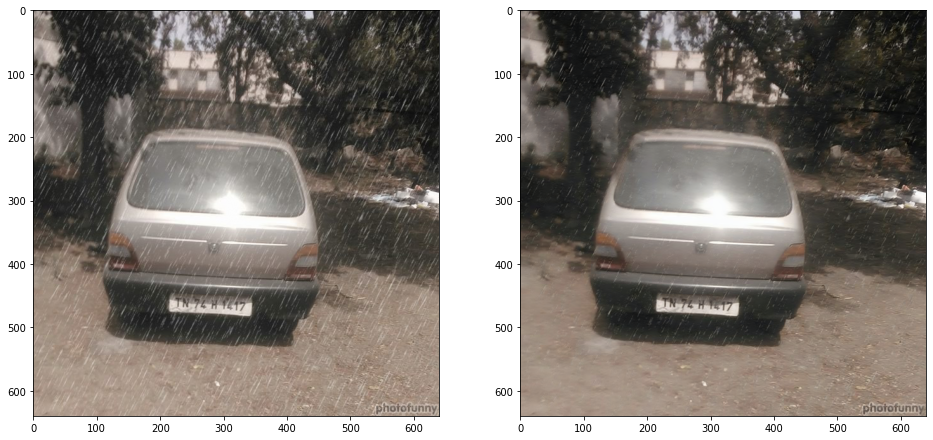

[INFO] loading EAST text detector...
[INFO] text detection took 0.613372 seconds


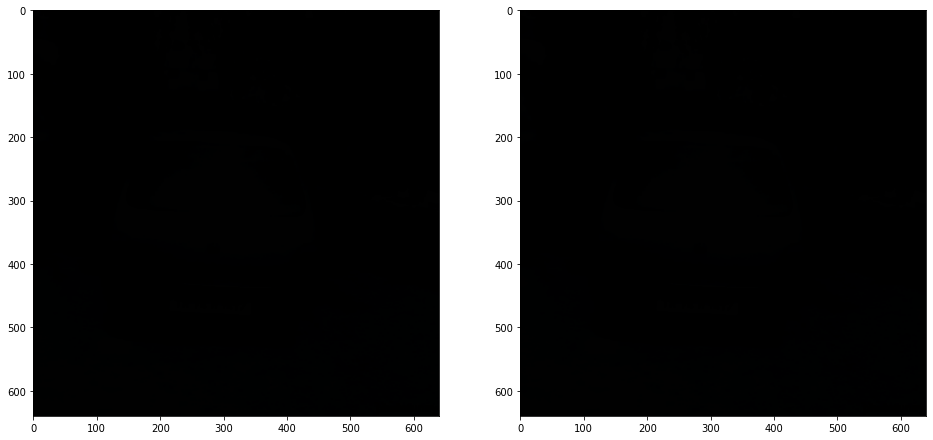

In [26]:
imn = input("Enter Image Name (example 1.png or 2.png) : ")
I = cv2.imread(imn)
print("Estimating Rain Intensity : ")
cnt = estimate_noise(I)
if cnt < 0.001:
    print("Very Low Rain or No Rain: "+str(cnt))
    text_detect(I,imn)
elif cnt < 0.002:
    print("Low Rain or Rain Drops : "+str(cnt))
    print("Removing Rain drops from image with GAN...")    
    os.system('python3 tools/test_model.py --weights_path model/derain_gan/derain_gan.ckpt-100000 --image_path '+imn)
    J=cv2.imread("derained.png")
    text_detect(J,"derained.png")
elif cnt < 0.005:
    print("Medium Rain :"+str(cnt))
    derain(imn)
    J = cv2.imread("derained.png")
    text_detect(J,"derained.png")
else :
    print("High Rain :"+str(cnt))
    derain(imn)
    J = cv2.imread("derained.png")
    text_detect(I,"derained.png")

Text(0.5, 1.0, 'License plate')

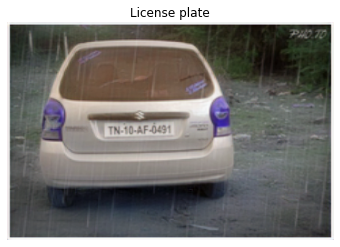

In [21]:
test_license_plate = cv2.imread("derained.png",cv2.IMREAD_COLOR) 
plt.imshow(test_license_plate) 
plt.axis('off') 
plt.title('License plate')

programming_fever's License Plate Recognition

Detected license plate Number is: as

a

ae

Sd



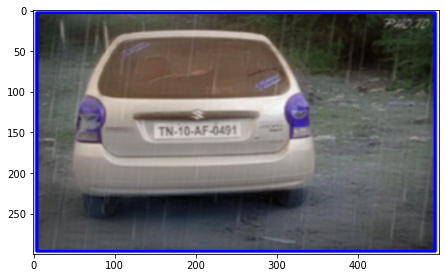

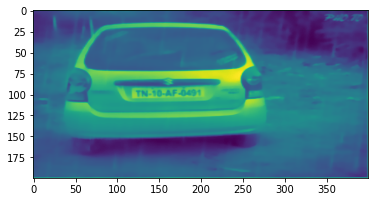

In [ ]:
img = cv2.resize(test_license_plate, (600,400) )

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
gray = cv2.bilateralFilter(gray, 13, 15, 15) 

edged = cv2.Canny(gray, 30, 200) 
contours = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
screenCnt = 0

for c in contours:
    
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.018 * peri, True)
 
    if len(approx) == 4:
        screenCnt = approx
        break

if screenCnt is None:
    detected = 0
    print ("No contour detected")
else:
     detected = 1

if detected == 1:
    cv2.drawContours(img, [screenCnt], -1, (0, 0, 255), 3)

mask = np.zeros(gray.shape,np.uint8)
new_image = cv2.drawContours(mask,[screenCnt],0,255,-1,)
new_image = cv2.bitwise_and(img,img,mask=mask)

(x, y) = np.where(mask == 255)
(topx, topy) = (np.min(x), np.min(y))
(bottomx, bottomy) = (np.max(x), np.max(y))
Cropped = gray[topx:bottomx+1, topy:bottomy+1]

text = pytesseract.image_to_string(Cropped, config='--psm 11')
print("programming_fever's License Plate Recognition\n")
print("Detected license plate Number is:",text)
img = cv2.resize(img,(500,300))
Cropped = cv2.resize(Cropped,(400,200))
fig1 = plt.figure(figsize=(16,8))
fig1.add_subplot(1, 2, 1)
plt.imshow(img)
plt.show()
#cv2.imshow('car',img)
#cv2.imshow('Cropped',Cropped)
fig1.add_subplot(1, 2, 2)
plt.imshow(Cropped)
plt.show()


In [ ]:
!pip show pytesseract

Name: pytesseract
Version: 0.3.7
Summary: Python-tesseract is a python wrapper for Google's Tesseract-OCR
Home-page: https://github.com/madmaze/pytesseract
Author: Samuel Hoffstaetter
Author-email: samuel@hoffstaetter.com
License: Apache License 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: Pillow
Required-by: 


In [ ]:
!apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 31 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,807 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 160983 files and directories currently installed.)
Preparing to unpack .../tesserac

In [ ]:
import pytesseract
resize_test_license_plate = cv2.resize(test_license_plate, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC) #img resizing
grayscale_resize_test_license_plate = cv2.cvtColor(resize_test_license_plate, cv2.COLOR_BGR2GRAY)  #gray scale
gaussian_blur_license_plate = cv2.GaussianBlur(grayscale_resize_test_license_plate, (5, 5), 0) #appying Gaussian blur


In [ ]:
!apt install libtesseract-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libleptonica-dev
The following NEW packages will be installed:
  libleptonica-dev libtesseract-dev
0 upgraded, 2 newly installed, 0 to remove and 31 not upgraded.
Need to get 2,755 kB of archives.
After this operation, 13.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libleptonica-dev amd64 1.75.3-3 [1,308 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libtesseract-dev amd64 4.00~git2288-10f4998a-2 [1,447 kB]
Fetched 2,755 kB in 2s (1,631 kB/s)
Selecting previously unselected package libleptonica-dev.
(Reading database ... 161030 files and directories currently installed.)
Preparing to unpack .../libleptonica-dev_1.75.3-3_amd64.deb ...
Unpacking libleptonica-dev (1.75.3-3) ...
Selecting previously unselected package libtesseract-dev.
Preparing to unpack .../libte

In [ ]:
new_predicted_result= pytesseract.image_to_string(gaussian_blur_license_plate, lang ='eng',config ='--oem 3 -l eng --psm 6 -c tessedit_char_whitelist = ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789') 
filter_new_predicted_result = "".join(new_predicted_result.split()).replace(":", "").replace("-", "") 
print(filter_new_predicted_result)
